# Perform outlier detection when variables outnumber samples
Based on https://nirpyresearch.com/detecting-outliers-using-mahalanobis-distance-pca-python/

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

f = "/Users/taylor/Desktop/power-replication/ddmra-debugging/OC_full/z_corrs.tsv.gz"

# Absorbance data, collected in the matrix X
data = pd.read_table(f)

# Data are in variables-by-samples, and first column is distance
data = data.T.iloc[1:]
print(data.shape)

(693, 34716)


10 components selected (5.78% variance explained)
(693, 10)


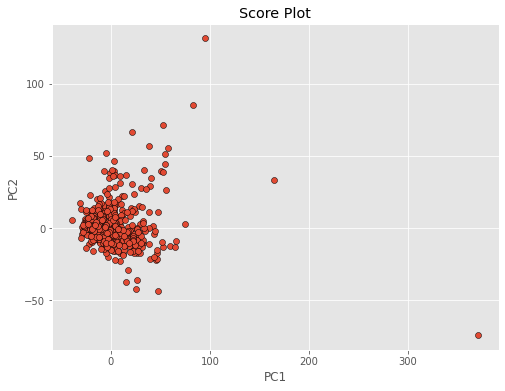

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the PCA object
pca = PCA()

# Run PCA on scaled data and obtain the scores array
pca_components = pca.fit_transform(StandardScaler().fit_transform(data))

# Identify number of components that explain 95% of variance
n_components = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.9)[0][0]
n_components = 10
perc_varex = np.cumsum(pca.explained_variance_ratio_)[n_components - 1] * 100
print(f"{n_components} components selected ({perc_varex:.02f}% variance explained)")

# Select first five
pca_components = pca_components[:, :n_components]
print(pca_components.shape)

# Score plot of the first 2 PC
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(pca_components[:, 0], pca_components[:, 1], edgecolors='k', cmap='jet')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

In [3]:
from sklearn.covariance import MinCovDet

# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet().fit(pca_components)

# Get the Mahalanobis distance
distances = robust_cov.mahalanobis(pca_components)

In [4]:
distances.shape

(693,)

In [5]:
# Use chi2 threshold, based on https://towardsdatascience.com/multivariate-outlier-detection-in-python-e946cfc843b3
from scipy.stats import chi2

# Cutoff (threshold) value from Chi-Square Distribution for detecting outliers 
cutoff = chi2.ppf(0.999, pca_components.shape[1])
print(cutoff)
bad_idx = np.where(distances > cutoff)[0]
print(bad_idx.shape)
print(bad_idx)

29.58829844507442
(135,)
[  2   7   8   9  10  16  21  22  24  26  28  29  32  41  42  46  48  50
  55  56  59  64  66  68  70  71  73  78  81  82 101 103 110 112 129 132
 136 141 144 153 160 168 170 180 190 196 197 198 201 202 213 214 223 228
 235 262 264 268 272 278 288 295 299 302 313 323 325 332 341 346 357 359
 362 370 373 376 381 382 384 386 390 391 399 403 406 408 423 429 450 453
 459 464 467 472 477 489 496 514 516 520 521 534 555 556 567 594 597 599
 609 610 623 636 660 663 664 666 667 668 671 674 675 678 679 680 681 682
 683 684 685 686 687 689 690 691 692]


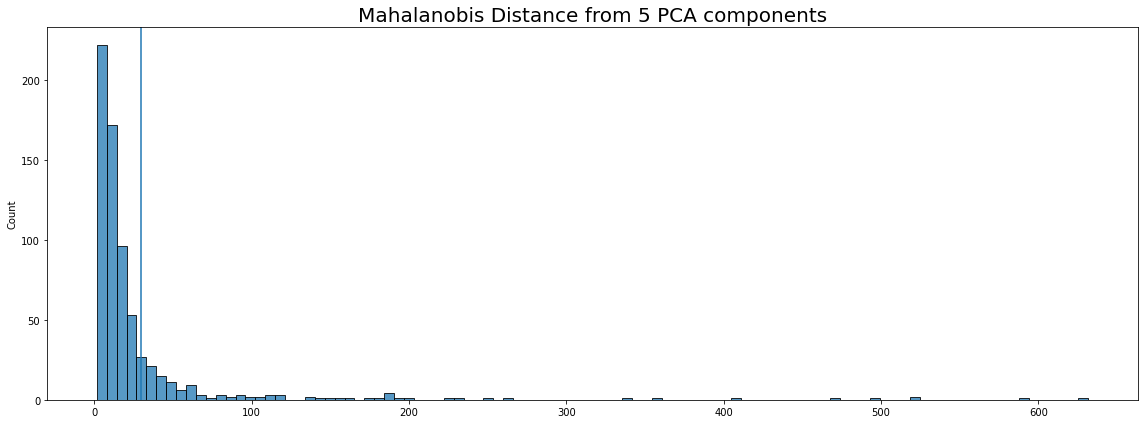

In [9]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(16, 6))
sns.histplot(distances[distances < 1000], ax=ax, bins=100)
ax.set_title("Mahalanobis Distance from 5 PCA components", fontsize=20)
ax.axvline(cutoff)
fig.tight_layout()
fig.savefig("mahalanobis_distance.png", facecolor="white")

/opt/miniconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 90.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

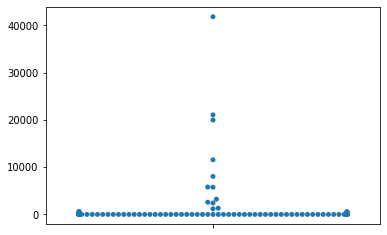

In [7]:
sns.swarmplot(y=distances)

In [11]:
len(sorted(distances[distances > 1000]))

12